Для лабораторной взят датасет, включающий в себя множество метрик по странам Южной Азии с 2000 по 2023 год. <br>
Страны в списке: Афганистан, Бангладеш, Бутан, Индия, Мальдивы, Непал, Пакистан, Шри-Ланка<br>
В качестве целевой переменной - ВВП страны за год на душу населения. В качестве модели прогнозирования выбран XGBoost.

In [387]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Обработка, нормализация данных и обучение модели

In [388]:
df = pd.read_csv("South_Asian_dataset.csv")

columns_to_convert = [
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
    'Life expectancy at birth, total (years)',
    'Mortality rate, infant (per 1,000 live births)',
    'Literacy rate, adult total (% of people ages 15 and above)',
    'School enrollment, primary (% gross)',
    'Access to electricity (% of population)',
    'People using at least basic drinking water services (% of population)',
    'People using at least basic sanitation services (% of population)',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
    'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Forest area (% of land area)',
    'Control of Corruption: Percentile Rank',
    'Political Stability and Absence of Violence/Terrorism: Estimate',
    'Regulatory Quality: Estimate',
    'Rule of Law: Estimate',
    'Voice and Accountability: Estimate',
    'Individuals using the Internet (% of population)',
    'Research and development expenditure (% of GDP)',
    'High-technology exports (% of manufactured exports)'
]

for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [389]:
df.head()

,Country,Year,GDP (current US$),GDP growth (annual %),GDP per capita (current US$),"Unemployment, total (% of total labor force) (modeled ILO estimate)","Inflation, consumer prices (annual %)","Foreign direct investment, net inflows (% of GDP)",Trade (% of GDP),Gini index,...,Renewable energy consumption (% of total final energy consumption),Forest area (% of land area),Control of Corruption: Percentile Rank,Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Rule of Law: Estimate,Voice and Accountability: Estimate,Individuals using the Internet (% of population),Research and development expenditure (% of GDP),High-technology exports (% of manufactured exports)
0,Afghanistan,2000,3.521418e+09,NaN,180.188369,7.955,NaN,0.004828,NaN,NaN,...,45.0,1.852782,4.787234,-2.438969,-2.080253,-1.780661,-2.031417,NaN,NaN,NaN
1,Afghanistan,2001,2.813572e+09,-9.431974,142.903364,7.958,NaN,0.024169,NaN,NaN,...,45.6,1.852782,NaN,NaN,NaN,NaN,NaN,0.004723,NaN,NaN
2,Afghanistan,2002,3.825701e+09,28.600001,182.174038,7.939,NaN,1.306950,NaN,NaN,...,37.8,1.852782,4.761905,-2.035034,-1.811546,-1.673473,-1.433421,0.004561,NaN,NaN
3,Afghanistan,2003,4.520947e+09,8.832278,199.643226,7.922,NaN,1.278493,NaN,NaN,...,36.7,1.852782,4.761905,-2.198372,-1.463108,-1.558294,-1.177571,0.087891,NaN,NaN
4,Afghanistan,2004,5.224897e+09,1.414118,221.830531,7.914,NaN,3.577104,NaN,NaN,...,44.2,1.852782,6.403941,-2.295682,-1.511549,-1.693925,-1.203034,0.105809,NaN,NaN


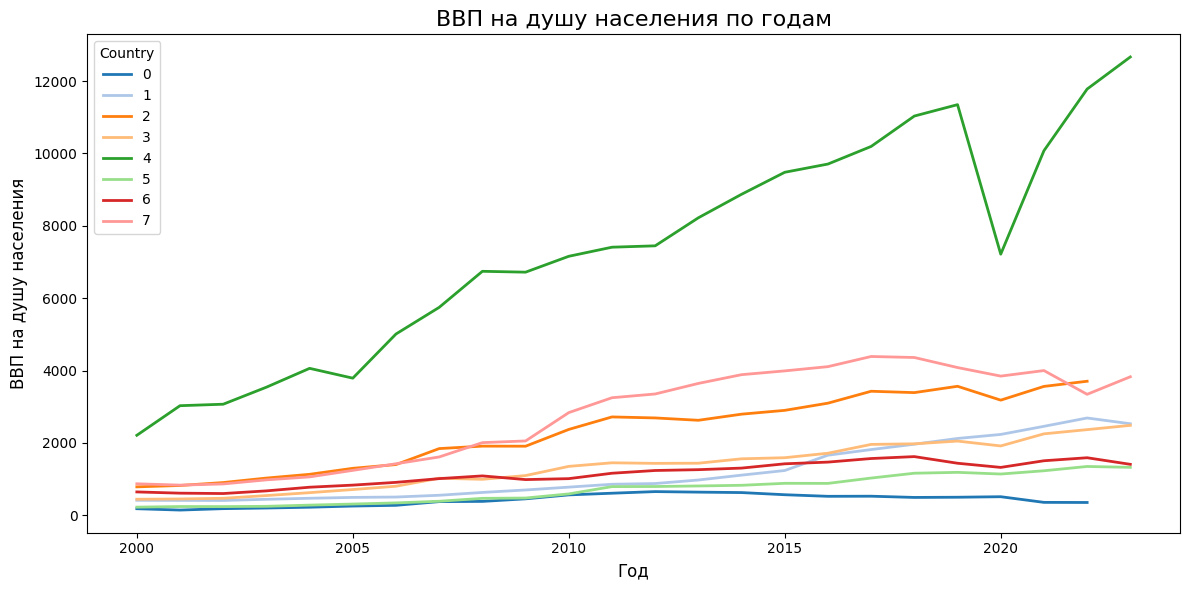

In [403]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='GDP per capita (current US$)', hue='Country', palette='tab20', linewidth=2)

plt.title('ВВП на душу населения по годам', fontsize=16)
plt.xlabel('Год', fontsize=12)
plt.ylabel('ВВП на душу населения', fontsize=12)
plt.xticks() 

plt.tight_layout()
plt.show()

In [391]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])

In [392]:
country_median_columns = [
    'Inflation, consumer prices (annual %)',
    'Foreign direct investment, net inflows (% of GDP)',
    'Life expectancy at birth, total (years)',
    'Mortality rate, infant (per 1,000 live births)',
    'Access to electricity (% of population)',
    'People using at least basic drinking water services (% of population)',
    'People using at least basic sanitation services (% of population)',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
    'Individuals using the Internet (% of population)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Forest area (% of land area)',
    'Control of Corruption: Percentile Rank',
    'Political Stability and Absence of Violence/Terrorism: Estimate',
    'Regulatory Quality: Estimate',
    'Rule of Law: Estimate',
    'Voice and Accountability: Estimate',
    'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
    'School enrollment, primary (% gross)',
    'GDP growth (annual %)',
    'Trade (% of GDP)',
]

for col in country_median_columns:
    df[col] = df.groupby('Country')[col].transform(lambda x: x.fillna(x.median()))

# В этих колонках очень мало данных (особенно жалко, что в Gini почти пустые значения)
df.drop([
    'Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)',
    'Literacy rate, adult total (% of people ages 15 and above)',
    'Research and development expenditure (% of GDP)',
    'High-technology exports (% of manufactured exports)',
    'Gini index',
    'GDP (current US$)',
    # 'Country'
], axis=1, inplace=True)

df['Trade (% of GDP)'].fillna(df['Trade (% of GDP)'].median(), inplace=True)

df = df.dropna(subset=['GDP per capita (current US$)']).reset_index(drop=True)

columns_to_normalize = [
    'GDP growth (annual %)', 
    'Unemployment, total (% of total labor force) (modeled ILO estimate)',
    'Inflation, consumer prices (annual %)', 'Foreign direct investment, net inflows (% of GDP)', 
    'Trade (% of GDP)', 'Population, total', 'Population growth (annual %)', 
    'Life expectancy at birth, total (years)', 'Mortality rate, infant (per 1,000 live births)', 
    'School enrollment, primary (% gross)', 'Urban population (% of total population)',
    'Access to electricity (% of population)', 
    'People using at least basic drinking water services (% of population)',
    'People using at least basic sanitation services (% of population)', 
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)',
    'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)', 
    'Renewable energy consumption (% of total final energy consumption)', 
    'Forest area (% of land area)', 'Control of Corruption: Percentile Rank', 
    'Political Stability and Absence of Violence/Terrorism: Estimate', 
    'Regulatory Quality: Estimate', 'Rule of Law: Estimate', 
    'Voice and Accountability: Estimate', 'Individuals using the Internet (% of population)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)'
]

scaler = MinMaxScaler(feature_range=(-1, 1))

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

country_median_columns_short = {
    'Inflation, consumer prices (annual %)': 'Inflation (%)',
    'Foreign direct investment, net inflows (% of GDP)': 'Foreign direct investment (% GDP)',
    'Life expectancy at birth, total (years)': 'Life Expectancy (years)',
    'Mortality rate, infant (per 1,000 live births)': 'Infant Mortality (per 1k)',
    'Access to electricity (% of population)': 'Access to Electricity (%)',
    'People using at least basic drinking water services (% of population)': 'Access to Water (%)',
    'People using at least basic sanitation services (% of population)': 'Access to Sanitation (%)',
    'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)': 'CO2 Emissions (t/cap)',
    'Individuals using the Internet (% of population)': 'Internet Users (%)',
    'Renewable energy consumption (% of total final energy consumption)': 'Renewable Energy (%)',
    'Forest area (% of land area)': 'Forest Area (%)',
    'Control of Corruption: Percentile Rank': 'Control of Corruption',
    'Political Stability and Absence of Violence/Terrorism: Estimate': 'Political Stability',
    'Regulatory Quality: Estimate': 'Regulatory Quality',
    'Rule of Law: Estimate': 'Rule of Law',
    'Voice and Accountability: Estimate': 'Voice and Accountability',
    'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 'PM2.5 Air Pollution',
    'School enrollment, primary (% gross)': 'Primary School Enrollment (%)',
    'GDP growth (annual %)': 'GDP Growth (%)',
    'Trade (% of GDP)': 'Trade (% GDP)',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'Unemployment (% of labor force) '
}

df.rename(columns=country_median_columns_short, inplace=True)

In [393]:
df.head()

,Country,Year,GDP Growth (%),GDP per capita (current US$),Unemployment (% of labor force),Inflation (%),Foreign direct investment (% GDP),Trade (% GDP),"Population, total",Population growth (annual %),...,CO2 Emissions (t/cap),PM2.5 Air Pollution,Renewable Energy (%),Forest Area (%),Control of Corruption,Political Stability,Regulatory Quality,Rule of Law,Voice and Accountability,Internet Users (%)
0,0,2000,0.026316,180.188369,0.103051,-0.582995,-0.926114,-0.309054,-0.973031,-0.488516,...,-0.994346,0.581698,-0.035242,-1.0,-0.907100,-0.818750,-1.000000,-0.890663,-1.000000,-0.896461
1,0,2001,-0.334896,142.903364,0.103489,-0.582995,-0.923893,-0.309054,-0.972827,-0.659722,...,-0.996093,0.576724,-0.022026,-1.0,-0.917902,-0.857812,-0.573509,-0.821745,-0.311696,-0.999996
2,0,2002,0.742558,182.174038,0.100715,-0.582995,-0.776636,-0.309054,-0.970991,0.733483,...,-0.997558,0.571427,-0.193833,-1.0,-0.907646,-0.621445,-0.824801,-0.808037,-0.520377,-1.000000
3,0,2003,0.182534,199.643226,0.098234,-0.582995,-0.779903,-0.309054,-0.968687,1.000000,...,-0.997396,0.564373,-0.218062,-1.0,-0.907646,-0.701229,-0.597616,-0.719251,-0.315173,-0.998081
4,0,2004,-0.027624,221.830531,0.097066,-0.582995,-0.516032,-0.309054,-0.967415,0.119216,...,-1.000000,0.554124,-0.052863,-1.0,-0.872280,-0.748760,-0.629200,-0.823803,-0.335595,-0.997668


In [394]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Разделение на признаки и целевую переменную
X = df.drop(columns=['GDP per capita (current US$)'])
y = df['GDP per capita (current US$)']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели XGBoost
model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод RMSE
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 240.4026488335344


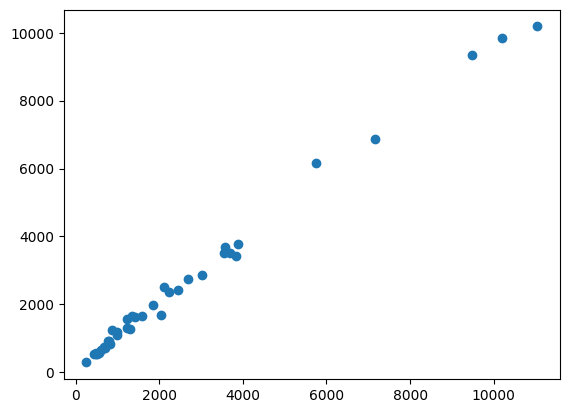

In [395]:
plt.scatter(y_test, y_pred)
plt.show()

# Изучение важности отдельных фич 

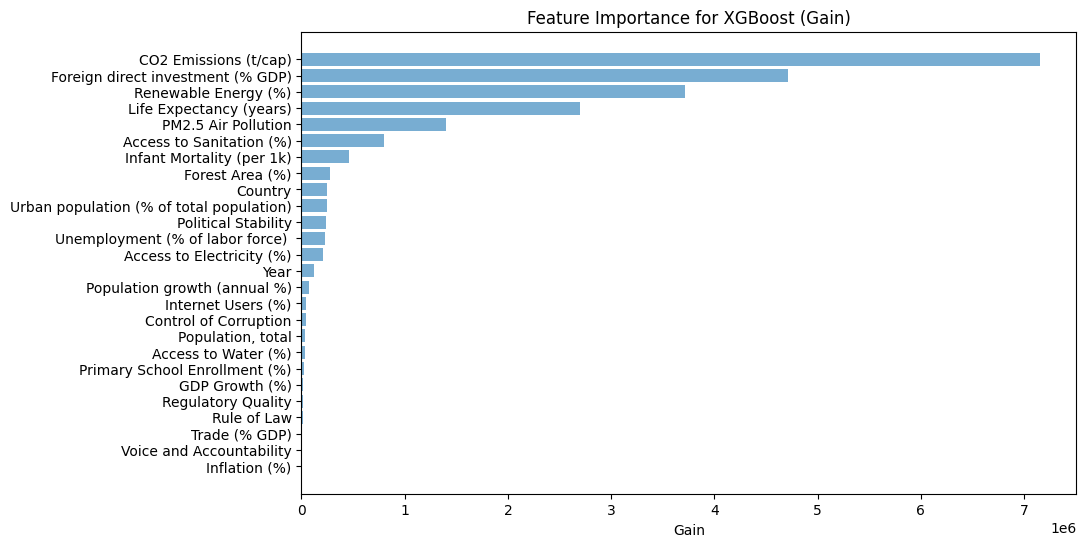

In [396]:
importance = model.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Gain'])
importance_df = importance_df.sort_values(by='Gain', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Gain'], alpha=0.6)
plt.xlabel('Gain')
plt.title('Feature Importance for XGBoost (Gain)')
plt.gca().invert_yaxis() 
plt.show()

Выбросы CO2, загрязнение воздуха и инвестиции связаны с развитием промышленности, что значительно влияет на общий уровень производства. <br> 
В то же время, продолжительность жизни, политическая стабильность и доступ к санитарии тоже отражают качество жизни в стране. <br> Как правило, страны с более высоким качеством жизни являются более богатыми.

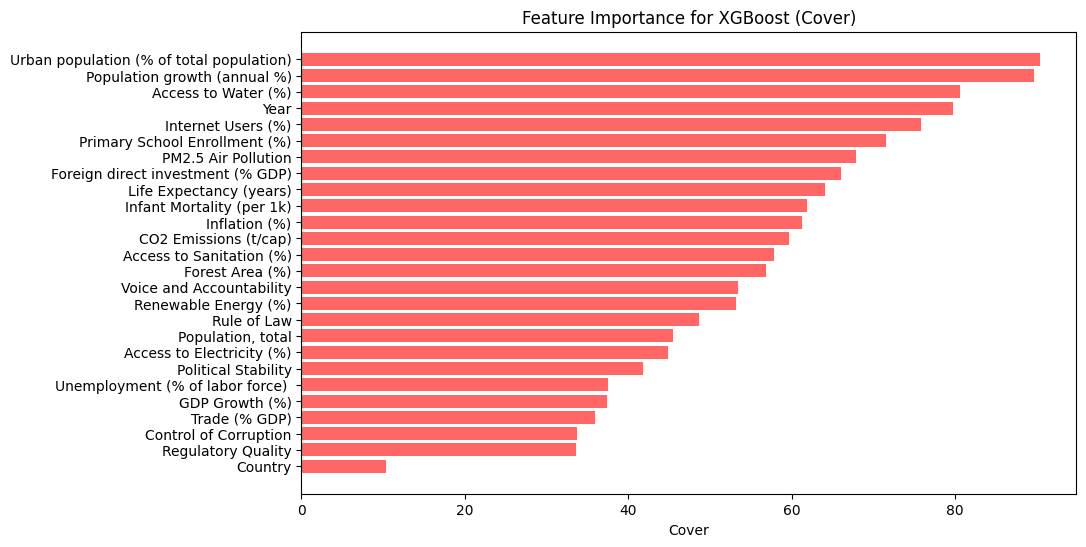

In [397]:
importance = model.get_booster().get_score(importance_type='cover')

importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Cover'])
importance_df = importance_df.sort_values(by='Cover', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Cover'], color='red', alpha=0.6)
plt.xlabel('Cover')
plt.title('Feature Importance for XGBoost (Cover)')
plt.gca().invert_yaxis()
plt.show()

По этому графику можно сказать, что модель достаточно равномерно охватывает входные данные

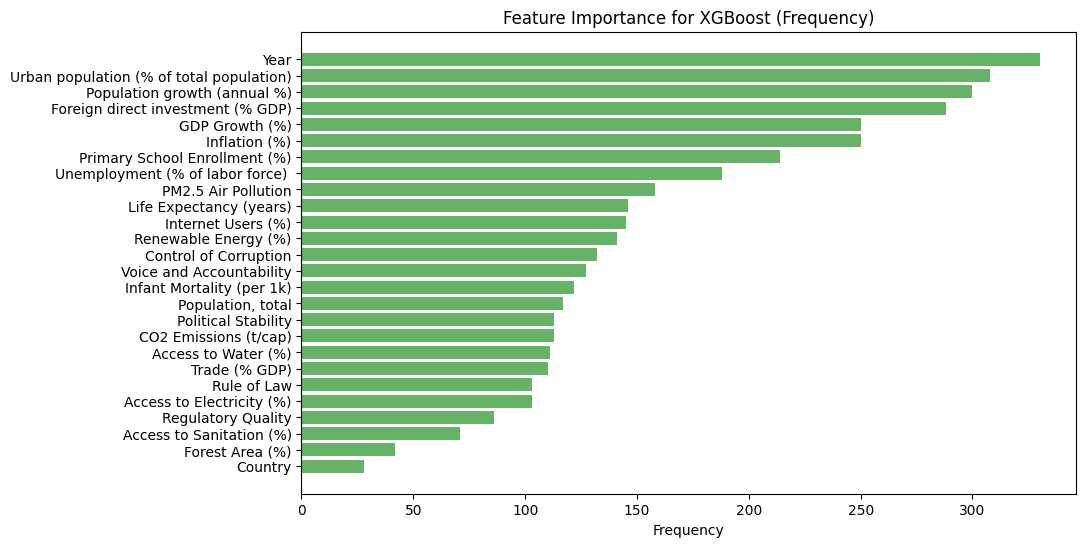

In [398]:
importance = model.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Frequency'])
importance_df = importance_df.sort_values(by='Frequency', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Frequency'], color='green', alpha=0.6)
plt.xlabel('Frequency')
plt.title('Feature Importance for XGBoost (Frequency)')
plt.gca().invert_yaxis() 
plt.show()

Если честно, мало что могу сказать про это..

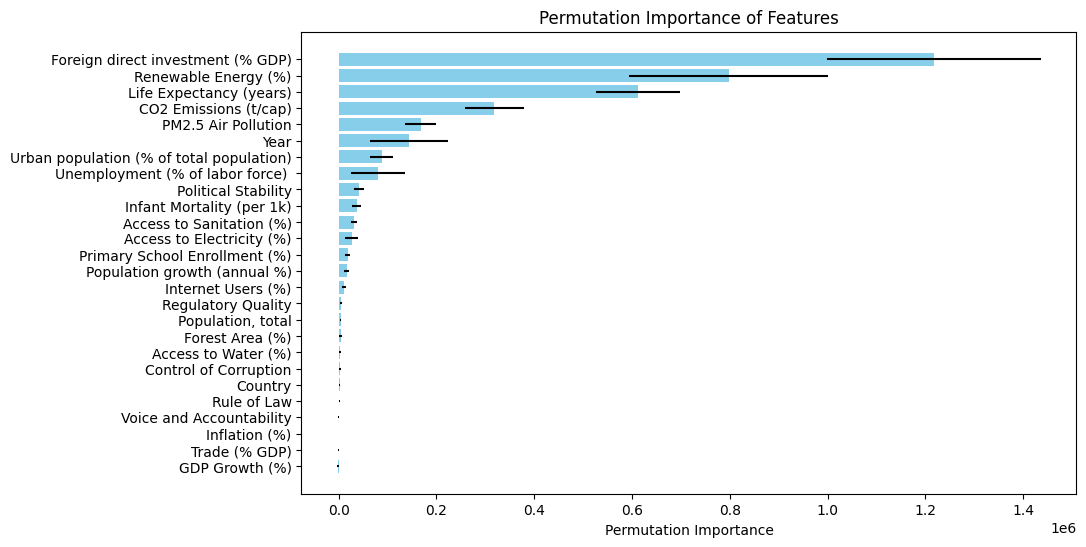

In [399]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')

importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean,
    'Importance Std': result.importances_std
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Importance Std'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.gca().invert_yaxis()
plt.show()

Результаты перестановки признаков показали результат схожий с Gain, и выводы можно сделать соотвествующие. Первые 5 самых важных фич оказались теми же, что и для Gain. <br>
Из интересных различний - значение года по данной метрике заметно выше, чем у Gain.

Изучим вклад отдельных признаков в прогнозы

In [400]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0,:])

Отобразим в более понятной форме (чтобы все поместилось на экран)

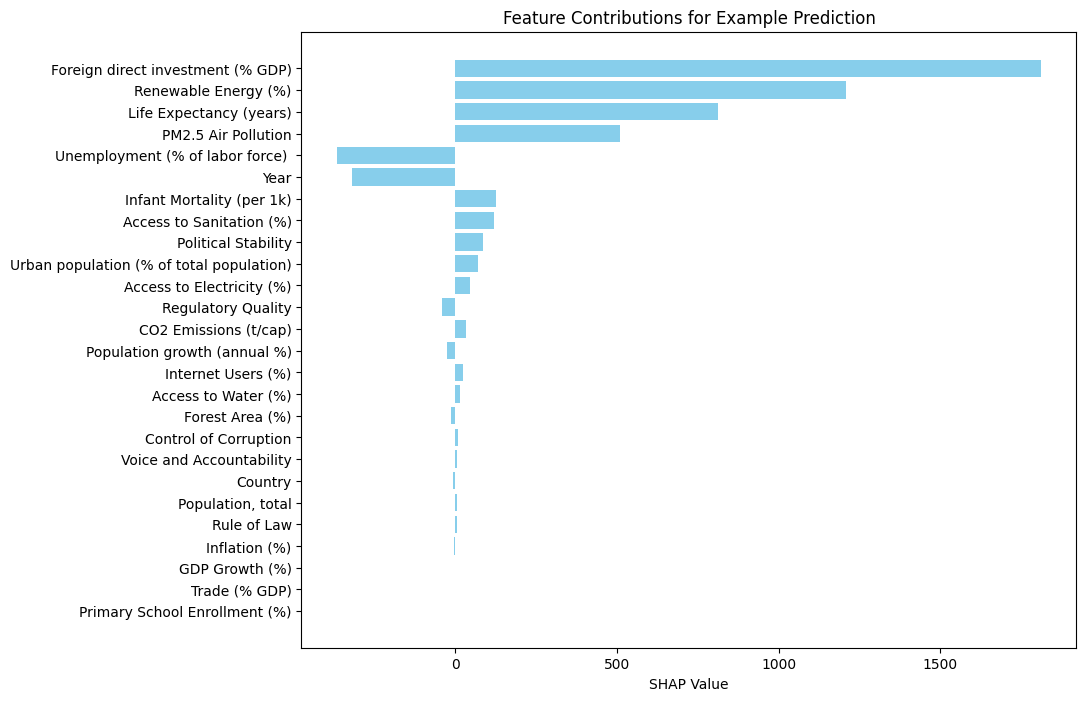

In [401]:
example_index = 4
example_shap_values = shap_values[example_index]
example_features = X_test.iloc[example_index]

shap_contributions = pd.DataFrame({
    'Feature': example_features.index,
    'Feature Value': example_features.values,
    'SHAP Value': example_shap_values
})

shap_contributions['|SHAP Value|'] = shap_contributions['SHAP Value'].abs()
shap_contributions = shap_contributions.sort_values(by='|SHAP Value|', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(shap_contributions['Feature'], shap_contributions['SHAP Value'], color='skyblue')
plt.xlabel("SHAP Value")
plt.title("Feature Contributions for Example Prediction")
plt.show()


Страна из первого прогноза имеет относительно небольшой ввп на душу населения. На увеличние прогноза повлиял высокий уровень городского населения, никзий уровень безработицы, относительно большая доля пользователей интернета. Все остальные факторы, в особенности те, которые являются важными согласно Gain и Importance Permutation, очень сильно снизили прогноз модели.

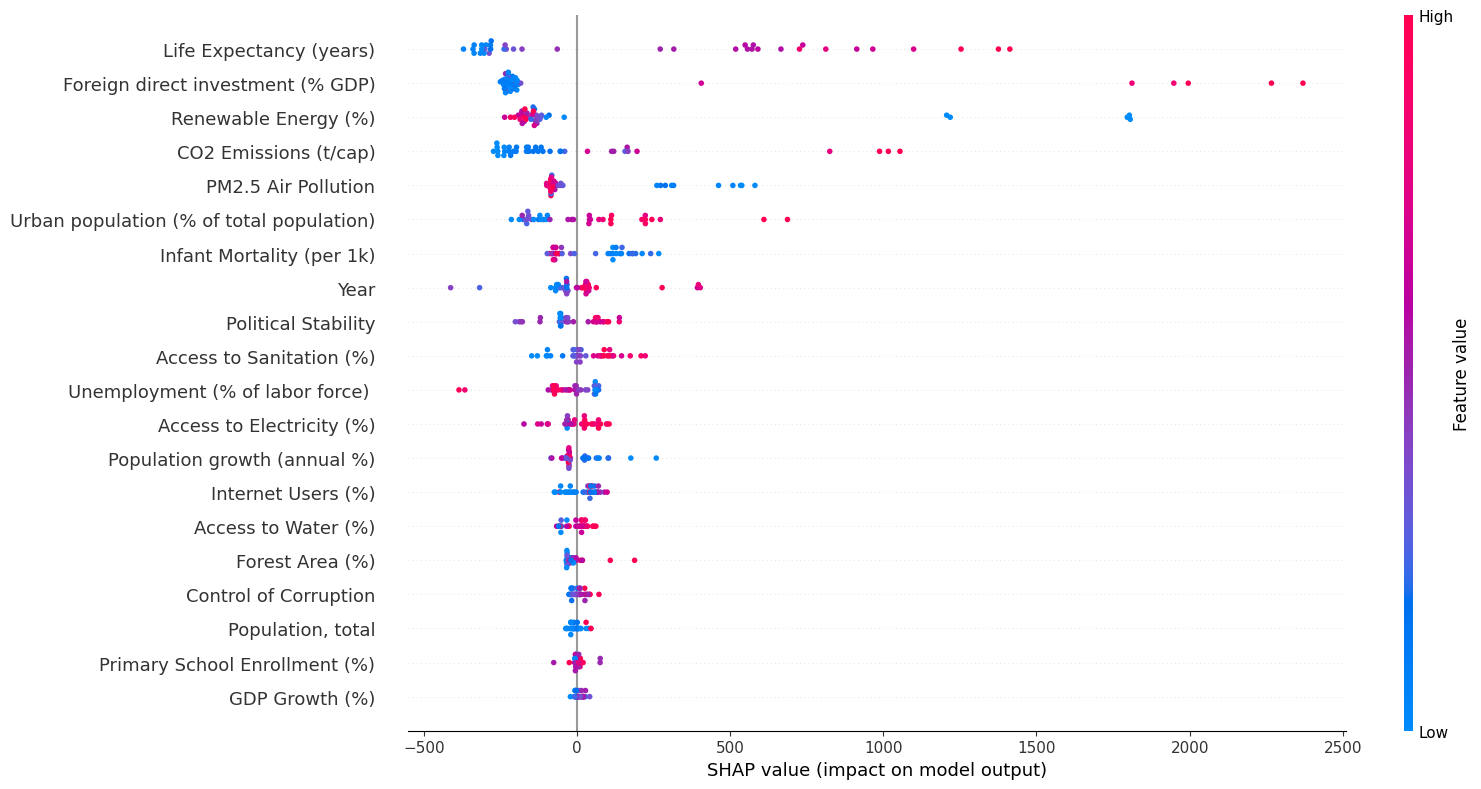

In [402]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_size=[16,8])

По данном графику можно заключить, что качество жизни (Длительность жизни, санитария, политическая стабильность, отсутствие безработицы) косвенно или напрямую говорят о более высоком ВВП в стране.<br>
Снижение качества воздуха и увеличение выбросов тоже положительно влияют на ВВП. Стоит учесть, что ни одна из исследуемых страны не являются развитой. <br>
Использование дешевой, грязной энергии является самым простым способом для таких стран выйти из нищеты, повысить до определенного уровня качество жизни. <br>
Эти выводы совпадают с важностью фич, полученной для Gain и для перестановки, но еще и говорят о том, в каком направлении они склоняют модель.

Вывод: Выяснилось, что данные о качестве жизни, косвенные показатели уровня производства, и некоторые финансовые показатели могут обеспечить достаточное количество информации для прогнозирования ВВП на душу населения. <br>5 наиболее важных факторов более высокого уровня ВВП составили: 
* Высокие выбросы углерода, 
* Низкое качество воздуха,
* Высокая продолжительность жизни, 
* Наличие иностранных инвестиций,  
* Невысокое использование возобновляемых источников энергии.

Думаю, если бы в датасете были развитые страны, то результат бы отличался. Но для развивающихся юнжо-азиатских стран получился такой, возможно не самый приятый, результат.